In [ ]:
# The Policy gradient model

# Used code from: https://github.com/awjuliani/DeepRL-Agents/blob/master/Vanilla-Policy.ipynb

# NOTES ###################################################################
# Achieved significant learning with the catcher environment
# -> results were evident after ~ 200 episodes with batches of 10 episodes


In [ ]:
import tensorflow as tf
import numpy as np
from ple import PLE
import pygame
import import_ipynb
from ple.games.catcher import Catcher
import pickle

from Utils import *
from Game import Pong

##############################
# TODO: 
# - understand the loss function? 
##############################

gamma = 0.99
learning_rate = 0.01
state_size = 7
num_actions = 2
hidden_size = 8

RENDER = True
LOAD = True
SAVE = False
MAX_SCORE = 21
total_episodes = 10000 
max_frames = 10000
update_frequency = 10
collection_frequency = 50

# calculate the discounted rewards
def discount_rewards(r):
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
        
    discounted_r -= np.mean(discounted_r)
    discounted_r /= np.std(discounted_r + 10e-7)
    
    return discounted_r

# the model 
class PolicyNetworks(tf.keras.Model):
    def __init__(self):
        super(PolicyNetworks, self).__init__()
        self.hidden_layer_1 = tf.keras.layers.Dense(hidden_size, activation='relu')
        self.output_layer = tf.keras.layers.Dense(num_actions, activation='softmax')

    def call(self, x):
        H1_output = self.hidden_layer_1(x)
        probs = self.output_layer(H1_output)
        return probs

# calculating the loss function
def pg_loss(probs, actions, rewards):    
    indexes = tf.range(0, tf.shape(probs)[0]) * tf.shape(probs)[1] + actions
    responsible_probs = tf.gather(tf.reshape(probs, [-1]), indexes)
    loss = -tf.reduce_mean(tf.math.log(responsible_probs) * rewards)
    return loss

optimizer = tf.optimizers.Adam(learning_rate)

# calculate gradients and perform gradient descent
def train_step(model, states, actions, rewards):    
    
    with tf.GradientTape() as tape:
        probs = model(states)
        loss = pg_loss(probs, actions, rewards)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

# Declare Policy Gradient Networks
PG_model = PolicyNetworks()

i = 1
total_reward = []
total_length = []

# train start
while i < total_episodes + 1:
    
    pygame.init()
    game = Pong(width=256, height=200, MAX_SCORE=MAX_SCORE)
    game.screen = pygame.display.set_mode(game.getScreenDims(), 0, 32)
    env = PLE(game, fps=30, 
              display_screen=RENDER, 
              force_fps=False,
              rng=np.random.RandomState(1),
              reward_values={'tick': 0.0, 
                             'win': 0.0, 'loss': 0.0, 
                             'positive': 1.0, 'negative': -1.0}
             )
    env.init()
    
    # get the possible actions
    possible_actions = game.actions 
    action_names = ['up', 'down']
    
    # for some reason breaks without this    
    env.act(env.NOOP)
    
    s = process_state(env.getGameState()).reshape(1,state_size)[0]
    running_reward = 0
    ep_history = []

    for j in range(max_frames):
        
        # Probabilistically pick an action given our network outputs.
        s = np.expand_dims(s, 0)
        
        # return probability distributions + chooses an action based on probabilities
        a_dist = PG_model(s).numpy()
        a = np.random.choice(a_dist[0], p=a_dist[0])
        a = np.argmax(a_dist == a)
        
        # perform action and save to history 
        r = env.act(possible_actions[action_names[a]])
        s1 = process_state(env.getGameState()).reshape(1,state_size)[0] 
        ep_history.append([s, a, r, s1])
        s = s1
        running_reward += r

        if env.game_over():            
            pygame.quit()            
            
            # Load the weights
            if i == 1 and LOAD:
                PG_model.load_weights('./Weights/PG_pong_v3_12500.h5')
            
            ep_history = np.array(ep_history, dtype=object)
            
            # get the rewards
            ep_history[:, 2] = discount_rewards(ep_history[:, 2])
            
            # cycle through the collected samples and create an array with the states
            np_states = np.array(ep_history[0, 0])
            for idx in range(1, ep_history[:, 0].size):
                np_states = np.append(np_states, ep_history[idx, 0], axis=0)

            # Update the network parameter
            if i % update_frequency == 0 and i != 0:
                train_step(PG_model, np_states, ep_history[:, 1], ep_history[:, 2])
                
                # save the weights
                if SAVE: 
                    PG_model.save_weights('./Weights/PG_pong_v3.h5')
                    
                print('Weights Updated')                
                
            print("Total reward after {} episodes is {}".format(i, running_reward))

            total_reward.append(running_reward)
            total_length.append(j)         
            
            if i % collection_frequency == 0:
                with open("./Rewards_Files/rewards-ep-" + str(i) + ".txt", "wb") as file:
                    pickle.dump(total_reward, file)   
            break
            
    i += 1

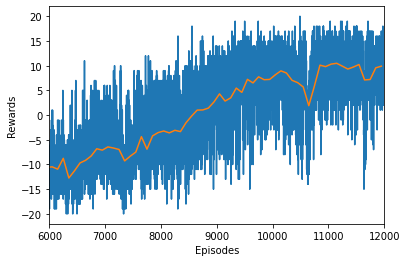

In [3]:
import matplotlib.pyplot as plt
import pickle
import numpy as np

with open("./Rewards_Files/rewards-ep-pong-v3-12500.txt", "rb") as fp1:   # Unpickling
    b = pickle.load(fp1)
    
array = []    
mean_array = []
for i in range(len(b)):
    
    array.append(b[i])
    
    if i % 100 == 0:
        mean = np.mean(array)
        mean_array.append(mean)
        array = []
    

x1 = np.array(range(1,6456)) + 5550
y1 = b
x2 = np.array(range(0, 6450, 100)) + 5550
y2 = mean_array

plt.plot(x1,y1)
plt.plot(x2,y2)
plt.ylabel('Rewards')
plt.xlabel('Episodes')
plt.ylim(-22, 22)
plt.xlim(6000, 12000)

plt.show()